In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [ ]:
class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0 #derivative of L with respect to that variable, initially 0 to assume every value doesnt impact the output
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self,other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    return out

  def __neg__(self, other):
    return self * -1


  def __sub__(self, other):
    return self + (-other)

  def __radd__(self, other):
    return self + other

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self,other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad

    out._backward= _backward
    return out


  def __pow__(self,other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
      self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward
    return out

  def __rmul__(self, other):
      return self * other

  def __truediv__(self, other):
    return self * other**-1


  def exp(self):
    x=self.data
    out = Value(math.exp(x), (self, ), 'exp')
    def _backward():
      self.grad += out.data *out.grad
    out._backward = _backward
    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    return out

  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
     if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    topo
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [ ]:
a = Value(2.0)
a.exp()

Value(data=7.38905609893065)

In [ ]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [ ]:
#neuron example:

#inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias of the neuron
b = Value(6.848, label='b')
#x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 +b; n.label='n'
o = n.tanh(); o.label='o'
o.backward()

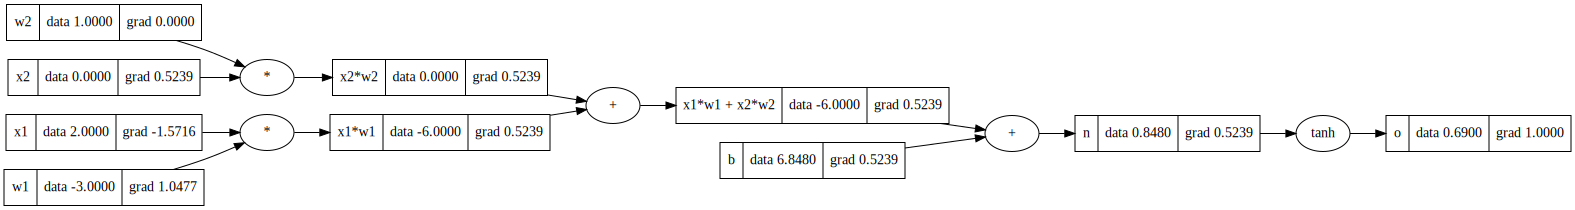

In [ ]:
draw_dot(o)

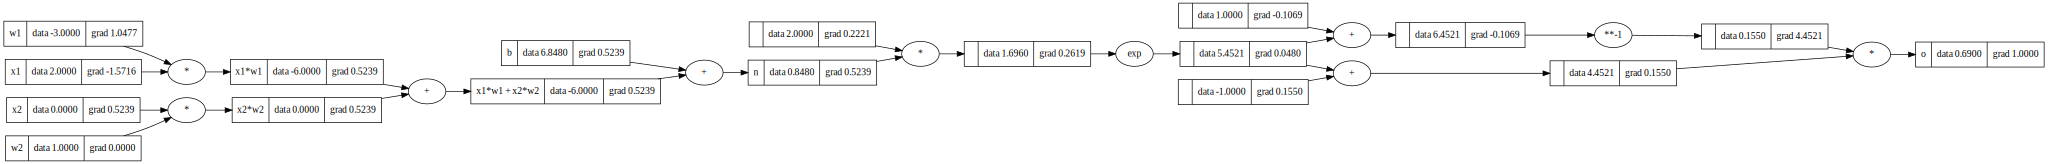

In [ ]:
#neuron example:

#inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias of the neuron
b = Value(6.848, label='b')
#x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 +b; n.label='n'
e = (2*n).exp()
o = (e - 1)/ (e +1)
o.label = 'o'
o.backward()
draw_dot(o)

In [ ]:
#how to do all of this in pytorch
import torch

x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8817335870195432]).double(); b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())


0.7072866506587729
---
x2 0.49974559379989486
w2 0.0
x1 -1.4992367813996845
w1 0.9994911875997897


In [ ]:
torch.tensor([2.0, 3.2, 4.5])

tensor([2.0000, 3.2000, 4.5000])

In [ ]:
class Neuron:

  def __init__(self,nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    act = sum(wi*xi for wi, xi in zip(self.w, x)) +self.b
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer: #list of neurons

  def __init__(self, nin, nout): #nout = how many neurons/output is wanted
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP: #multi layer perception
  def __init__(self, nin, nouts):
    sz = [nin] +nouts
    self.layers = [Layer(sz[i], sz[i+1])for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

#2 layers - 4 neurons per layer - 4 weights + 1 bias per neuron
#3 inputs -> 1 output

In [ ]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)

Value(data=0.9143320504641209)

In [ ]:
xs = [
    [2.0, 3.0, -1.0], # 1.0 target
    [3.0, -1.0, 0.5], #-1.0 target
    [0.5, 1.0, 1.0], #-1.0 target
    [1.0, 1.0, -1.0], #1.0 target
]

ys = [1.0, -1.0, -1.0, 1.0]  # desired targets

In [ ]:
for k in range(120):
  #forward pass
  ypred = [n(x) for x in xs] #models prediction
  loss = sum((yout-ygt)**2 for ygt, yout in zip(ys, ypred))
#the lower the loss, the more accurate the prediction is
  #backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  #update
  for p in n.parameters():
    p.data += -0.05 * p.grad
  print(k, loss.data)

0 0.06774066192819062
1 0.06407366313380776
2 0.060770747846522116
3 0.05778081160506425
4 0.05506183744226481
5 0.05257896808328895
6 0.05030304796220768
7 0.04820950686510233
8 0.046277495446526
9 0.04448920881475032
10 0.04282935219006535
11 0.041284715049610475
12 0.03984382894066616
13 0.03849669042077641
14 0.03723453512990545
15 0.03604965233060486
16 0.03493523171761118
17 0.03388523614103818
18 0.03289429527724174
19 0.0319576163387966
20 0.031070908725890495
21 0.030230320148007375
22 0.029432382232406167
23 0.02867396401798052
24 0.027952232034389003
25 0.02726461590539409
26 0.026608778606108406
27 0.025982590656904163
28 0.025384107660201567
29 0.02481155068642367
30 0.024263289096917696
31 0.02373782545833376
32 0.023233782257754552
33 0.02274989017309594
34 0.022284977690763923
35 0.021837961893715906
36 0.021407840269083822
37 0.020993683406306723
38 0.020594628475033176
39 0.020209873387499855
40 0.019838671563155497
41 0.019480327224387018
42 0.0191341911616362
43 0.0

In [ ]:
n(x) #predicts for x=  [2.0, 3.0, -1.0]
ypred #predicts for all the values in xs

Value(data=0.9593543013591049)

# Summary

- neural net = 1. mathametical expression that takes input as a data, weights, and a bias 2. forward pass 3. loss function that measures accuracy of predictions (low when it matches the targets) 4. use backprop to get the gradient then tune the parameters to decrease the loss, and iterate that process many times, in a process called gradient descent.
